In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skimage.transform import AffineTransform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import z5py
import re
from typing import Dict, List

from transforms3d.euler import euler2mat, mat2euler
from scipy.optimize import minimize

In [3]:
from cryofib.n5_utils import read_volume, tif2n5

from cryofib.affine_utils import parse_points, objective_function, params_to_transform, fit_affine_transform, get_affine_transform, get_translation_transform, get_scaling_transform

# Set paths

In [4]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
em_dir = scratch_dir / "em"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"

## Convert tif to n5 files

In [7]:
# tif2n5(tif_dir=em_dir,
#         n5_path=em_dir / "em.n5",
#         n5_key="raw",
#         reg_exp="*.tiff",
#         description="Raw em data transposed to match fluorescence coordinates (xyz --> yzx)",
#         order="zyx",
#         unit="nm",
#         resolution=(30, 30, 40),
#         roi=None)

Reading tif files from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em
Read (1410, 1386, 1610) of type uint8
Writing to /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5, key raw
Assigning attributes of the dataset


In [10]:
tif2n5(tif_dir=segm_em_nuclei_dir,
        n5_path=segm_em_nuclei_dir / "em_nuclei.n5",
        n5_key="raw",
        reg_exp="*.tiff",
        description="Raw em data transposed to match fluorescence coordinates (xyz --> yzx)",
        order="zyx",
        unit="nm",
        resolution=(30, 30, 40),
        roi=None)

Reading tif files from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/segm_em_nuclei
Read (1410, 1386, 1610) of type uint8
Writing to /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/segm_em_nuclei/em_nuclei.n5, key raw
Assigning attributes of the dataset


In [ ]:
# tif2n5(tif_dir=fluo_dir,
#         n5_path=fluo_dir / "fluo.n5",
#         n5_key="raw",
#         reg_exp="*.tiff",
#         description="Raw fluorescence data",
#         order="zyx",
#         unit="nm",
#         resolution=(1849.5, 221.4, 221.4),
#         roi=None)

## Load n5

In [5]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
em_dir = scratch_dir / "em"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"
alignment_points_path = scratch_dir / "Probe_coordinates_for_Alyona.txt"

In [6]:
fluo_path = fluo_dir / "fluo.n5"
em_path = em_dir / "em.n5"
segm_em_nuclei_path = segm_em_nuclei_dir / "em_nuclei.n5"

In [12]:
f_fluo = z5py.File(fluo_path, "r")
f_em = z5py.File(em_path, "r")
f_segm_em_nuclei = z5py.File(segm_em_nuclei_path, "r")

In [20]:
np.array(f_em["raw"].attrs["ref_affine_transform"]["R"])

array([[ 9.97290717e-01, -7.35610333e-02, -0.00000000e+00,
        -1.29347738e+04],
       [-5.85773859e-03, -7.94152563e-02,  9.96824410e-01,
         1.09508498e+05],
       [-7.33274336e-02, -9.94123730e-01, -7.96309992e-02,
         1.29746573e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [11]:
roi = np.s_[:]
fluo = read_volume(f_fluo, "raw", roi)
em = read_volume(f_em, "raw", roi)
segm_em_nuclei = read_volume(f_segm_em_nuclei, "raw", roi)

Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5
Read volume with shape (55, 3343, 1482), data type uint8
Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5
Read volume with shape (1410, 1386, 1610), data type uint8
Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/segm_em_nuclei/em_nuclei.n5
Read volume with shape (1410, 1386, 1610), data type uint8


In [ ]:
image_names = {"fluo": "HT6_3Dcrop",
                "em": "F107_a2_ali_crop_from70_bin2_ORS-denoised_YZX"}

coords = parse_points(alignment_points_path, image_names)

fluo
{'val': '156', 'x': '458', 'y': '498', 'z': '4'}
{'val': '159', 'x': '462', 'y': '747', 'z': '7'}
{'val': '148', 'x': '431', 'y': '569', 'z': '10'}
{'val': '112', 'x': '445', 'y': '548', 'z': '14'}
{'val': '52', 'x': '553', 'y': '667', 'z': '1'}
{'val': '125', 'x': '433', 'y': '569', 'z': '11'}
em
{'val': '103', 'x': '70', 'y': '890', 'z': '686'}
{'val': '124', 'x': '1443', 'y': '725', 'z': '833'}
{'val': '131', 'x': '478', 'y': '1035', 'z': '1082'}
{'val': '66', 'x': '359', 'y': '933', 'z': '1312'}
{'val': '101', 'x': '959', 'y': '116', 'z': '439'}
{'val': '114', 'x': '478', 'y': '1018', 'z': '1116'}


In [ ]:
coords

{'fluo': array([[  3, 497, 457],
        [  6, 746, 461],
        [  9, 568, 430],
        [ 13, 547, 444],
        [  0, 666, 552],
        [ 10, 568, 432]]),
 'em': array([[ 685,  889,   69],
        [ 832,  724, 1442],
        [1081, 1034,  477],
        [1311,  932,  358],
        [ 438,  115,  958],
        [1115, 1017,  477]])}

In [ ]:
em[1081, 1034,  477]

131

In [ ]:
em.shape

(1410, 1386, 1610)

In [ ]:
fluo[10, 568, 432]

125

## Affine transform

Transform should consist of 
- translation along all axes  
- rotation only around Z (within the plane where fluorescence has good resolution) and around Y (within the plane where FIB-SEM has the best resolution). The other angle is probably impossible to get right, because during acquizition there is already some rotation and then it's taken into account already, and there is not enough resolution for it anyway.

So to parametrize the rotation in terms of euler angles, it makes sense to rotate first around Y, then around Z

Prior to this affine transform there is a scaling step to bring both volumes to the same resolution? --> set based on resolution of the datasets

In [10]:
np.diag(f_em["raw"].attrs["resolution"])

array([[30,  0,  0],
       [ 0, 30,  0],
       [ 0,  0, 40]])

In [11]:
R = euler2mat(0, 0, -np.pi * 0.5, 'syxz')
arr = coords["em"].T
rotated = np.dot(R, arr)

NameError: name 'coords' is not defined

In [12]:
plt.scatter(arr[0, :], arr[1, :])
plt.scatter(rotated[0, :], rotated[1, :])

plt.scatter(arr[0, 1], arr[1, 1])

NameError: name 'arr' is not defined

In [18]:
get_affine_transform([1, 2, 3], [0, 0, -np.pi * 0.5])

array([[ 6.123234e-17,  1.000000e+00,  0.000000e+00,  1.000000e+00],
       [-1.000000e+00,  6.123234e-17, -0.000000e+00,  2.000000e+00],
       [-0.000000e+00,  0.000000e+00,  1.000000e+00,  3.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [19]:
get_translation_transform([1, 2, 1])

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [20]:
get_scaling_transform(f_em["raw"].attrs["resolution"])

array([[30,  0,  0,  0],
       [ 0, 30,  0,  0],
       [ 0,  0, 40,  0],
       [ 0,  0,  0,  1]])

In [108]:
def fit_affine_transform(ref_points, moving_points, ref_res, moving_res):
    ref_points = np.vstack([ref_points, np.ones(ref_points.shape[1])])
    S_ref = get_scaling_transform(ref_res)
    ref_res = np.array(ref_res + [0]) / 2
    ref_res = ref_res[:, None]
    print("res", ref_res, "points", np.dot(S_ref, ref_points))
    print(ref_res.shape, ref_points.shape)
    # ref_points = np.dot(S_ref, ref_points) - ref_res
    ref_points = np.dot(S_ref, ref_points)
    print("REF")
    print(ref_points)

    moving_points = np.vstack([moving_points, np.ones(moving_points.shape[1])])
    S_moving = get_scaling_transform(moving_res)
    moving_res = np.array(moving_res + [0]) / 2
    moving_res = moving_res[:, None]
    # moving_points = np.dot(S_moving, moving_points) - moving_res
    moving_points = np.dot(S_moving, moving_points)
    print("Moving")
    print(moving_points)

    # Plot points
    plt.scatter(ref_points[2, :], ref_points[0, :], label="ref")
    plt.scatter(moving_points[2, :], moving_points[0, :], label="move")
    
    plt.xlabel("x")
    plt.ylabel("y")
    

    t_0 = np.mean(ref_points, axis=1) - np.mean(moving_points, axis=1)
    print("t_0", t_0)
    res = minimize(objective_function, [t_0[0], t_0[1], t_0[2], 0, 0], args=(ref_points, moving_points), tol=0.001)

    print("Success", res.success)
    print(res.x)

    R = params_to_transform(res.x)
    new_points = np.dot(R, moving_points)
    plt.scatter(new_points[2, :], new_points[0, :], label="new")
    plt.legend()
    plt.show()

    
    return ref_points, moving_points, new_points, res.x, R

res [[924.75]
 [110.7 ]
 [110.7 ]
 [  0.  ]] points [[5.548500e+03 1.109700e+04 1.664550e+04 2.404350e+04 0.000000e+00]
 [1.100358e+05 1.651644e+05 1.257552e+05 1.211058e+05 1.474524e+05]
 [1.011798e+05 1.020654e+05 9.520200e+04 9.830160e+04 1.222128e+05]
 [1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00]]
(4, 1) (4, 5)
REF
[[5.548500e+03 1.109700e+04 1.664550e+04 2.404350e+04 0.000000e+00]
 [1.100358e+05 1.651644e+05 1.257552e+05 1.211058e+05 1.474524e+05]
 [1.011798e+05 1.020654e+05 9.520200e+04 9.830160e+04 1.222128e+05]
 [1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00]]
Moving
[[2.055e+04 2.496e+04 3.243e+04 3.933e+04 1.314e+04]
 [2.667e+04 2.172e+04 3.102e+04 2.796e+04 3.450e+03]
 [2.760e+03 5.768e+04 1.908e+04 1.432e+04 3.832e+04]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]]
t_0 [-14615.1  111738.72  77360.32      0.  ]
[35336.57584086 45751.07810401 17088.61097845 19748.13411249
 32951.39241523]
[35336.57584086 45751.07810401 17088.610

[2199.62034728 1579.49054008   16.9369268  1030.67076087 2017.56737696]
[2199.6203473  1579.49054007   16.93692681 1030.67076088 2017.56737698]
[2199.6203473  1579.49054006   16.93692681 1030.67076089 2017.56737696]
[2199.62044664 1579.49002082   16.93706224 1030.67066265 2017.56777617]
[2199.62046855 1579.49013949   16.9369063  1030.67064254 2017.56709875]
[1768.5737884   137.24849538  110.41307723  918.40415653 1863.8339802 ]
[1768.57378839  137.24849537  110.41307722  918.40415651 1863.83398018]
[1768.57378841  137.24849538  110.41307723  918.40415652 1863.8339802 ]
[1768.5737884   137.24849537  110.41307724  918.40415653 1863.83398019]
[1768.57384059  137.24918174  110.41321621  918.40413731 1863.83451246]
[1768.57383336  137.248012    110.41303678  918.40407972 1863.8337631 ]
[2168.61699313 1200.99489826  124.69649865 1044.907989   1422.02706237]
[2168.61699312 1200.99489826  124.69649864 1044.90798899 1422.02706235]
[2168.61699313 1200.99489826  124.69649865 1044.907989   1422.02

[6.09473144e+02 2.48310705e-02 8.20122062e+02 4.53435160e+02
 1.38719863e+03]
[6.09473144e+02 2.48310584e-02 8.20122062e+02 4.53435160e+02
 1.38719863e+03]
[6.09473144e+02 2.48310717e-02 8.20122062e+02 4.53435160e+02
 1.38719863e+03]
[6.09473223e+02 2.45973571e-02 8.20121875e+02 4.53435080e+02
 1.38719912e+03]
[6.09473224e+02 2.43935533e-02 8.20122168e+02 4.53435324e+02
 1.38719837e+03]
[6.09473136e+02 2.48311044e-02 8.20122069e+02 4.53435164e+02
 1.38719863e+03]
[6.09473136e+02 2.48311019e-02 8.20122069e+02 4.53435164e+02
 1.38719863e+03]
[6.09473136e+02 2.48310897e-02 8.20122069e+02 4.53435164e+02
 1.38719863e+03]
[6.09473136e+02 2.48311030e-02 8.20122069e+02 4.53435164e+02
 1.38719863e+03]
[6.09473215e+02 2.45973890e-02 8.20121882e+02 4.53435084e+02
 1.38719912e+03]
[6.09473216e+02 2.43935836e-02 8.20122175e+02 4.53435329e+02
 1.38719836e+03]
[6.09473134e+02 2.48311106e-02 8.20122070e+02 4.53435165e+02
 1.38719862e+03]
[6.09473134e+02 2.48311081e-02 8.20122070e+02 4.53435165e+02
 1.

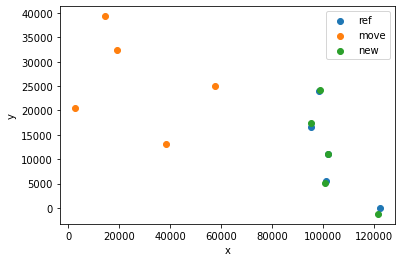

In [135]:
ref_points = coords["fluo"].T
moving_points = coords["em"].T

ref_points, moving_points, new_points, x, R = fit_affine_transform(ref_points[:, :-1], moving_points[:, :-1], f_fluo["raw"].attrs["resolution"], f_em["raw"].attrs["resolution"])

In [137]:
moving_points

array([[2.055e+04, 2.496e+04, 3.243e+04, 3.933e+04, 1.314e+04],
       [2.667e+04, 2.172e+04, 3.102e+04, 2.796e+04, 3.450e+03],
       [2.760e+03, 5.768e+04, 1.908e+04, 1.432e+04, 3.832e+04],
       [1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]])

In [138]:
print(new_points)

[[ 5.11669870e+03  1.10969958e+04  1.74479964e+04  2.42155474e+04
  -1.23444480e+03]
 [ 1.10185002e+05  1.65164376e+05  1.25834522e+05  1.21093497e+05
   1.47405862e+05]
 [ 1.00776385e+05  1.02065398e+05  9.53513577e+04  9.87209469e+04
   1.21581690e+05]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]]


In [149]:
mat2euler(R, axes="rzyx")

(-0.02852119647096875, 0.0, -1.6373064350732913)

In [147]:
mat2euler(R, axes="szyx")

(0.0018960614990137206, 0.02845811957036491, -1.637333416074736)

In [139]:
print(new_points - ref_points)

[[-4.31801299e+02 -4.17837247e-03  8.02496387e+02  1.72047375e+02
  -1.23444480e+03]
 [ 1.49202295e+02 -2.43729345e-02  7.93223588e+01 -1.23031182e+01
  -4.65384247e+01]
 [-4.03415188e+02 -2.25508328e-03  1.49357701e+02  4.19346853e+02
  -6.31110320e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [140]:
ref_points

array([[5.548500e+03, 1.109700e+04, 1.664550e+04, 2.404350e+04,
        0.000000e+00],
       [1.100358e+05, 1.651644e+05, 1.257552e+05, 1.211058e+05,
        1.474524e+05],
       [1.011798e+05, 1.020654e+05, 9.520200e+04, 9.830160e+04,
        1.222128e+05],
       [1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00]])

In [146]:
print(R)

[[ 9.99593298e-01 -1.89529264e-03  2.84542785e-02 -1.54529299e+04]
 [-2.85173298e-02 -6.64340537e-02  9.97383215e-01  1.09790052e+05]
 [-0.00000000e+00 -9.97789018e-01 -6.64610835e-02  1.27570851e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Text(0, 0.5, 'y')

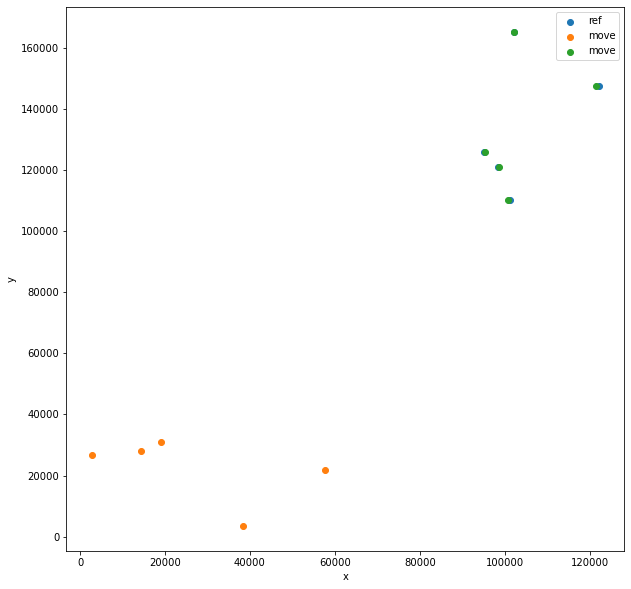

In [142]:
plt.figure(figsize=(10, 10))
plt.scatter(ref_points[2, :], ref_points[1, :], label="ref")
plt.scatter(moving_points[2, :], moving_points[1, :], label="move")
plt.scatter(new_points[2, :], new_points[1, :], label="move")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

In [143]:
new_points

array([[ 5.11669870e+03,  1.10969958e+04,  1.74479964e+04,
         2.42155474e+04, -1.23444480e+03],
       [ 1.10185002e+05,  1.65164376e+05,  1.25834522e+05,
         1.21093497e+05,  1.47405862e+05],
       [ 1.00776385e+05,  1.02065398e+05,  9.53513577e+04,
         9.87209469e+04,  1.21581690e+05],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00]])

In [87]:
np.linalg.inv(R)

array([[ 9.96087064e-01, -8.83773820e-02,  1.85729176e-20,
         2.61714590e+04],
       [-2.28013207e-03, -2.56989968e-02, -9.99667126e-01,
         1.29411502e+05],
       [ 8.83479635e-02,  9.95755492e-01, -2.57999504e-02,
        -1.05353457e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Text(0, 0.5, 'y')

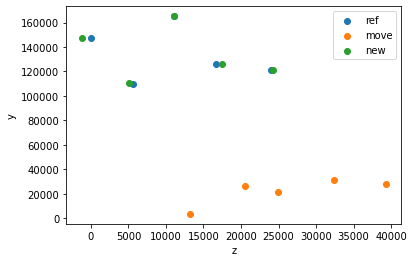

In [144]:
plt.scatter(ref_points[0, :], ref_points[1, :], label="ref")
plt.scatter(moving_points[0, :], moving_points[1, :], label="move")
plt.scatter(new_points[0, :], new_points[1, :], label="new")
plt.legend()
plt.xlabel("z")
plt.ylabel("y")

In [89]:
R_scale = R.copy()

In [90]:
print(R)

[[ 9.96087064e-01 -2.28013207e-03  8.83479635e-02 -1.64662131e+04]
 [-8.83773820e-02 -2.56989968e-02  9.95755492e-01  1.10544994e+05]
 [-0.00000000e+00 -9.99667126e-01 -2.57999504e-02  1.26650310e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [91]:
R

array([[ 9.96087064e-01, -2.28013207e-03,  8.83479635e-02,
        -1.64662131e+04],
       [-8.83773820e-02, -2.56989968e-02,  9.95755492e-01,
         1.10544994e+05],
       [-0.00000000e+00, -9.99667126e-01, -2.57999504e-02,
         1.26650310e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [92]:
for i in range(len(f_em["raw"].attrs["resolution"])):
    R_scale[:, i] *= f_em["raw"].attrs["resolution"][i]
    # R_scale[i, 3] *= f_em["raw"].attrs["resolution"][i]

In [93]:
f_em["raw"].attrs["resolution"]

[30, 30, 40]

[[ 1.01793217e+06  1.20751005e+06  5.11375072e+05  1.04844732e+06]
 [ 7.60607744e+05  5.55080948e+05  1.59934080e+06  7.58296591e+05]
 [-8.23330439e+05 -7.26648686e+05 -1.63614012e+04 -8.08035532e+05]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


In [94]:
print(R_scale)

[[ 2.98826119e+01 -6.84039621e-02  3.53391854e+00 -1.64662131e+04]
 [-2.65132146e+00 -7.70969904e-01  3.98302197e+01  1.10544994e+05]
 [-0.00000000e+00 -2.99900138e+01 -1.03199801e+00  1.26650310e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
[ 1.30206802e+00, -3.87356614e-01,  2.99703223e+01, 1.37783569e+05,
 2.92510688e+01, -8.70199929e+00,  -1.33408452e+00,  1.21702925e+05,
 -6.53296224e+00, -3.90400456e+01, -0.00000000e+00,  -1.53353979e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]

In [176]:
print(np.linalg.inv(R_scale))

[[ 3.33003581e-02 -1.48231614e-03  3.10639515e-20  6.91076451e+02]
 [-2.42097884e-04 -5.43874955e-03 -2.44000285e-02  4.02012209e+03]
 [ 1.44674224e-03  3.25011875e-02 -7.25884694e-03 -2.93315338e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Transform

In [178]:
em.shape

(1410, 1386, 1610)

In [179]:
from scipy.ndimage import affine_transform

In [180]:
em_transformed = affine_transform(em, R_scale)